This notebook is to test if Qhot and statusvalve or statusasst variables work better when tacken separatly

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Import necessary libraries
from src.models import RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn

# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")

# Close all open plots
plt.close('all')

In [3]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output.mat')
data_out = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'input_separate.mat') # separated inputs Qhot and status valve or asst to test
data_sep = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__, separate, separate_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_sep['separate'], data_sep['separate_val']
nExp = yExp.size

print(separate[0,0].shape) 
    #plt.plot(dExp[0, 1][:,4])
    #plt.legend(['d1', 'd2', 'd3', 'd4', 'd5'])


(30240, 2)


In [4]:
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
input_size = 6
u = torch.zeros(nExp, t_end, input_size)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = input_size-1

# Fill input and output tensors with data
for j in range(nExp):
    #inputActive = (torch.from_numpy(dExp[0, j]))
    #if input_size ==4:
    u[j, :, :4] = (torch.from_numpy(dExp[0, j][:, :-1])) #suppress last column
    #else :
    u[j, :, 4:6] = (torch.from_numpy(separate[0, j][:,:]))
        
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [5]:
#Set dimensions for RNN layers
idd = input_size
hdd = 10
ldd = 1
odd = yExp[0, 0].shape[1]

# Initialize RNN model
RNN = RNNModel(idd, hdd, ldd, odd)

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 200

# Initialize array to store loss values
LOSS = np.zeros(epochs)


In [9]:
#looping code

# Set number of epochs
epochs = 300

# Set dimensions for RNN layers
idd = input_size
odd = yExp[0, 0].shape[1]

# Initialize variable to track the smallest loss
best_loss = 1
best_hdd_ldd = None 

for hdd in [50]:  # hdd goes from 10 to 100 (inclusive), step by 10       150-200
    for ldd in [2]: #1-5
        print(f"Training RNN with hdd={hdd} and ldd={ldd}")
        
        # Initialize RNN model
        RNN = RNNModel(idd, hdd, ldd, odd)
        
        # Define loss function
        MSE = nn.MSELoss()

        # Define optimization method
        learning_rate = 5.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
        optimizer.zero_grad()

        # Initialize array to store loss values
        LOSS = np.zeros(epochs)

        # Train the RNN model
        for epoch in range(epochs):
            # Adjust learning rate at certain epochs
            if epoch == epochs - epochs // 2:
                learning_rate = 1.0e-3
                optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
            if epoch == epochs - epochs // 6:
                learning_rate = 1.0e-4
                optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
            
            optimizer.zero_grad()

            # Get RNN output for training data
            yRNN = RNN(u)
            yRNN = torch.squeeze(yRNN)

            # Calculate loss and backpropagate
            loss = MSE(yRNN, y)
            loss.backward()
            optimizer.step()

            # Print loss for the current epoch
            print(f"Epoch: {epoch + 1} \t||\t Loss: {loss.item()}")
            LOSS[epoch] = loss.item()
        print(f"loss for model with hdd={hdd}, ldd={ldd} : loss={LOSS[-1]}")

        # Check if this model has the smallest loss
        final_loss = LOSS[-1]  # Loss at the last epoch
        if final_loss < best_loss:
            best_loss = final_loss
            best_hdd_ldd = (hdd, ldd)
            
            # Save the model parameters with the lowest loss
            torch.save(RNN.state_dict(), 'best_RNN.pth')
            print(f"Best model so far saved with hdd={hdd}, ldd={ldd} and loss={best_loss}")
            
print(f"Training completed. Best model was with hdd={best_hdd_ldd[0]}, ldd={best_hdd_ldd[1]} and loss={best_loss}")

Training RNN with hdd=50 and ldd=2
Epoch: 1 	||	 Loss: 0.38103705644607544
Epoch: 2 	||	 Loss: 0.08944950997829437
Epoch: 3 	||	 Loss: 0.010943101719021797
Epoch: 4 	||	 Loss: 0.051439929753541946
Epoch: 5 	||	 Loss: 0.03217384219169617
Epoch: 6 	||	 Loss: 0.00616046879440546
Epoch: 7 	||	 Loss: 0.01370871439576149
Epoch: 8 	||	 Loss: 0.026816047728061676
Epoch: 9 	||	 Loss: 0.024754520505666733
Epoch: 10 	||	 Loss: 0.013311137445271015
Epoch: 11 	||	 Loss: 0.004691089037805796
Epoch: 12 	||	 Loss: 0.004203868098556995
Epoch: 13 	||	 Loss: 0.009108386933803558
Epoch: 14 	||	 Loss: 0.01254383847117424
Epoch: 15 	||	 Loss: 0.010857169516384602
Epoch: 16 	||	 Loss: 0.006613111589103937
Epoch: 17 	||	 Loss: 0.0037704783026129007
Epoch: 18 	||	 Loss: 0.0035641929134726524
Epoch: 19 	||	 Loss: 0.005045747384428978
Epoch: 20 	||	 Loss: 0.006761329714208841
Epoch: 21 	||	 Loss: 0.007357568480074406
Epoch: 22 	||	 Loss: 0.006464521400630474
Epoch: 23 	||	 Loss: 0.00492394994944334
Epoch: 24 	||

In [ ]:
# no loop code
# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    

    # Calculate loss and backpropagate
    loss = MSE(yRNN, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss

Epoch: 1 	||	 Loss: 1.027884602546692
Epoch: 2 	||	 Loss: 0.8316234350204468
Epoch: 3 	||	 Loss: 0.673373818397522
Epoch: 4 	||	 Loss: 0.5363656282424927
Epoch: 5 	||	 Loss: 0.4169749319553375
Epoch: 6 	||	 Loss: 0.3146504759788513
Epoch: 7 	||	 Loss: 0.22852693498134613
Epoch: 8 	||	 Loss: 0.1576223373413086
Epoch: 9 	||	 Loss: 0.10162818431854248
Epoch: 10 	||	 Loss: 0.060937460511922836
Epoch: 11 	||	 Loss: 0.0357561819255352
Epoch: 12 	||	 Loss: 0.02486603334546089
Epoch: 13 	||	 Loss: 0.024996284395456314
Epoch: 14 	||	 Loss: 0.03156062588095665
Epoch: 15 	||	 Loss: 0.04017464816570282
Epoch: 16 	||	 Loss: 0.04762255772948265
Epoch: 17 	||	 Loss: 0.052059073001146317
Epoch: 18 	||	 Loss: 0.052923478186130524
Epoch: 19 	||	 Loss: 0.05065859109163284
Epoch: 20 	||	 Loss: 0.04624943062663078
Epoch: 21 	||	 Loss: 0.04075749218463898
Epoch: 22 	||	 Loss: 0.035009078681468964
Epoch: 23 	||	 Loss: 0.029490724205970764
Epoch: 24 	||	 Loss: 0.02441573143005371
Epoch: 25 	||	 Loss: 0.019868

In [10]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :4] = (torch.from_numpy(dExp_val[0, j][:, :-1]))
    uval[j, :, 4:6] = torch.from_numpy(separate_val[0, j][:,:])
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))

# Get RNN output for validation data
yRNN_val = RNN(uval)
yRNN_val = yRNN_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yRNN_val, yval)

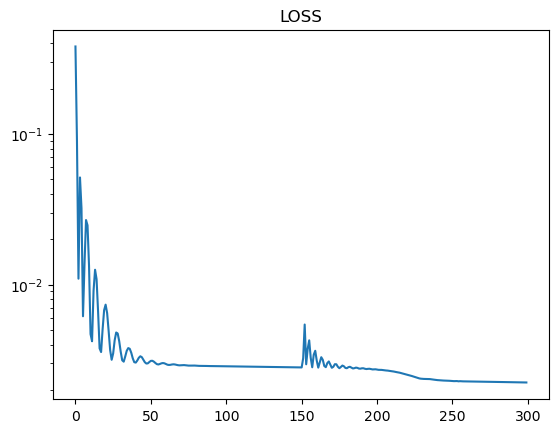

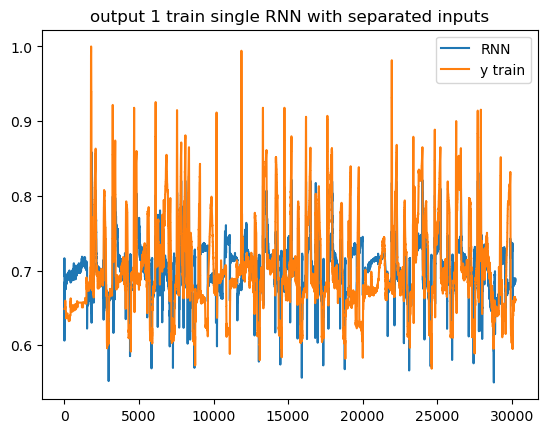

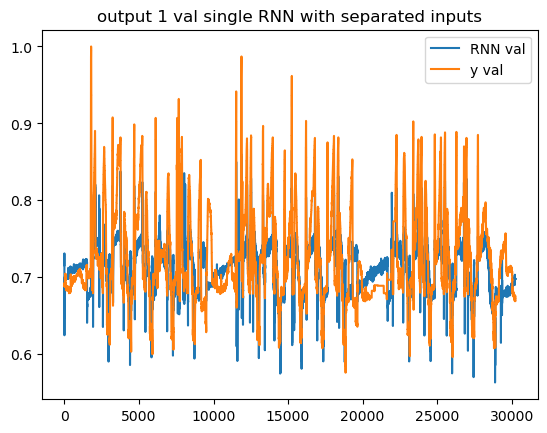

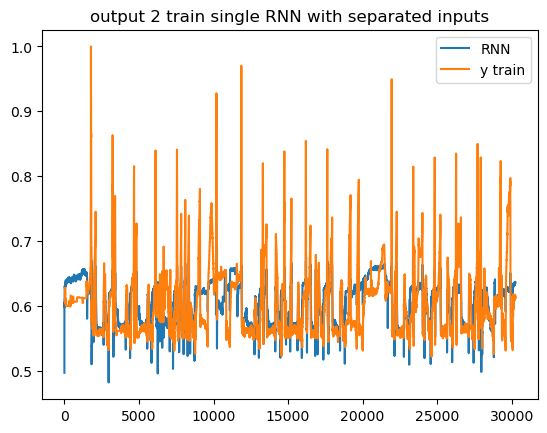

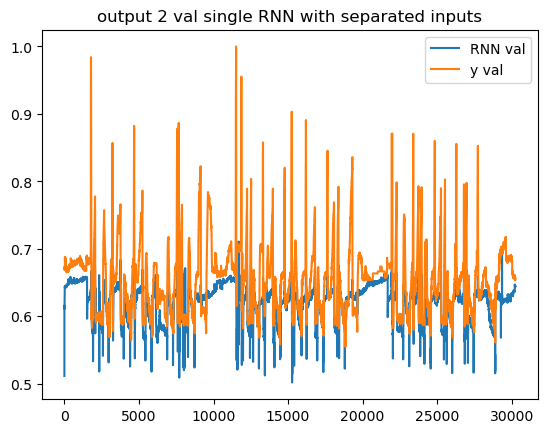

Loss Validation single RNN: 0.002750034909695387


In [15]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.yscale('log')
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yRNN[0, :, 0].detach().numpy(), label='RNN')
plt.plot(y[0, :, 0].detach().numpy(), label='y train')
plt.title("output 1 train single RNN with separated inputs")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yRNN_val[0, :, 0].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 0].detach().numpy(), label='y val')
plt.title("output 1 val single RNN with separated inputs")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yRNN[0, :, 1].detach().numpy(), label='RNN')
plt.plot(y[0, :, 1].detach().numpy(), label='y train')
plt.title("output 2 train single RNN with separated inputs")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yRNN_val[0, :, 1].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single RNN with separated inputs")
plt.legend()
plt.show()

# Save RNN output and validation data to file
#scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single RNN: {loss_val}")

In [ ]:
"""0.0036072 (1,1)
 0.0027561 (10,1)
 0.0024877(50,1)
 0.0023682 (100,1)
 0.0035695   (1,2)
 0.0027873   (10,2)
 0.0022469   (50,2)
 0.0028349   (100,2)"""

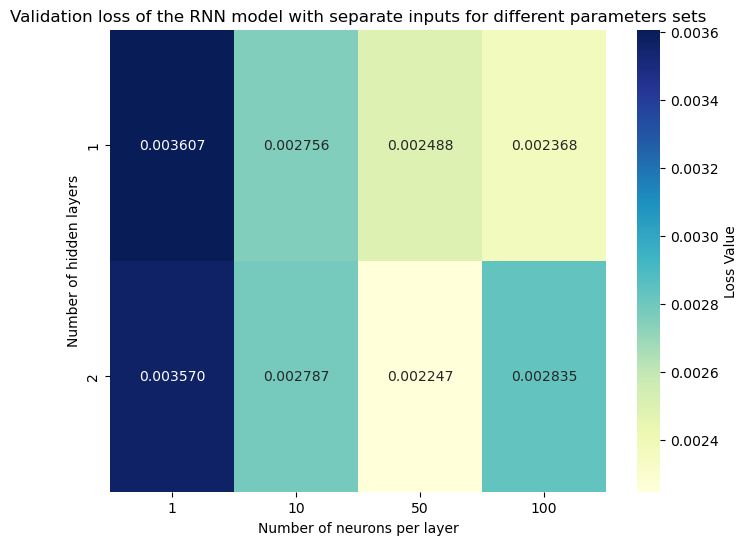

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for neurons, layers, and loss values for the LSTM model
data = {
    "neurons": [1, 10, 50, 100, 1, 10, 50, 100],
    "layers": [1, 1, 1, 1, 2, 2, 2, 2],
    "loss": [0.0036072, 0.0027561, 0.0024877, 0.0023682, 0.0035695, 0.0027873, 0.0022469, 0.0028349]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot the data for heatmap
pivot_table = df.pivot(index="layers", columns="neurons", values="loss")

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Loss Value'}, fmt=".6f")
plt.title("Validation loss of the RNN model with separate inputs for different parameters sets")
plt.xlabel("Number of neurons per layer")
plt.ylabel("Number of hidden layers")
plt.show()
